### Dwarf / low-luminosity AGN example

PyQSOFit can be used for more than just quasars! Let's take the dwarf/low-luminosity AGN RGG 118 (SDSS J152304.97+114553.5) as an example. We will estimate its BH mass. We will use pPXF to get subtract the stellar component (instead of PyQSOFit's stellar PCA templates). Then, determine the number of broad line components to fit by comparing the $\chi^2_\nu$ values. The narrow-lines are all tied together as usual!



In [1]:
%matplotlib inline
import glob, os,sys,timeit
import matplotlib
import numpy as np

#from pyqsofit.PyQSOFit import QSOFit
from PyQSOFit import QSOFit
from astropy.cosmology import FlatLambdaCDM

from astropy.io import fits
import astropy.constants as const
import astropy.units as u

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

QSOFit.set_mpl_style()

In [2]:
# Show the versions so we know what works
import astropy
import lmfit
import pyqsofit
import ppxf
print(astropy.__version__)
print(lmfit.__version__)
print(pyqsofit.__version__)
print(ppxf.__version__)

4.3.1
1.0.3
1.2.0
8.2.1


In [3]:
# pPXF setup
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.miles_util as lib

from os import path
ppxf_dir = path.dirname(path.realpath(lib.__file__))

add_noise = True
phot_fit = True

__Step 1: Download the SDSS spectrum__<br>

In [4]:
from astroquery.sdss import SDSS
from astropy import coordinates as coords

# RGG 118
pos = coords.SkyCoord.from_name('J152304.97+114553.5')
xid = SDSS.query_region(pos, spectro=True)
xid

ra,dec,objid,run,rerun,camcol,field,z,plate,mjd,fiberID,specobjid,run2d,instrument
float64,float64,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64,bytes4
230.770725216755,11.7648875109673,1237668331495752032,5322,301,2,142,0.0243035,2753,54234,127,3099637424066684928,26,SDSS


In [5]:
sp = SDSS.get_spectra(matches=xid)

In [6]:
data = sp[0]

path_ex = '/Users/legolason/study/mesfit/v1.2/PyQSOFit/example/' # The absolute path to the example directory 
path_out = '/Users/legolason/study/mesfit/v1.2/PyQSOFit/example/data/' # path of fitting results

# Requried
lam = 10**data[1].data['loglam']        # OBS wavelength [A]
flux = data[1].data['flux']             # OBS flux [erg/s/cm^2/A]
err = 1/np.sqrt(data[1].data['ivar'])   # 1 sigma error
z = data[2].data['z'][0]                # Redshift

# Optional
ra = data[0].header['plug_ra']        # RA
dec = data[0].header['plug_dec']      # DEC
plateid = data[0].header['plateid']   # SDSS plate ID
mjd = data[0].header['mjd']           # SDSS MJD
fiberid = data[0].header['fiberid']   # SDSS fiber ID

(0.0, 50.0)

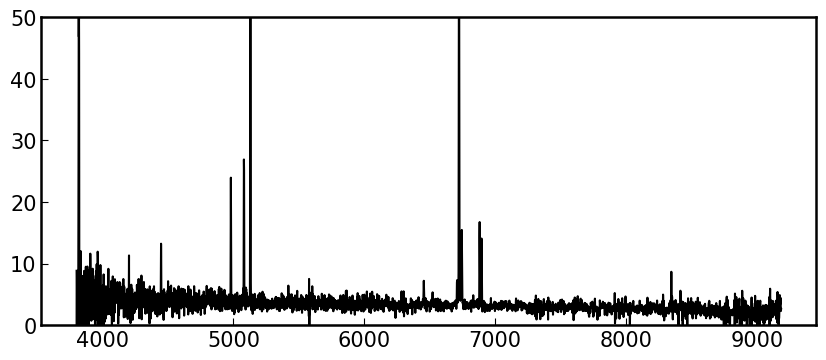

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10, 4))
ax.plot(lam, flux, color='k')
ax.set_ylim(0, 50)

__Step 1: Initial fitting with PyQSOFit__<br>

We will adjust the line sigmas in `qsopar.fits` to be narrow than a quasar would be.

In [31]:
"""
Create parameter file
lambda    complexname  minwav maxwav linename ngauss inisca minsca maxsca inisig minsig maxsig voff vindex windex findex fvalue vary
"""

newdata = np.rec.array([
(6564.61, r'H$\alpha$', 6400, 6800, 'Ha_br',   1, 0.1, 0.0, 1e10, 5e-3, 0.004/18,  0.05/18,   0.015/10, 0, 0, 0, 0.05 , 1),
(6564.61, r'H$\alpha$', 6400, 6800, 'Ha_na',   1, 0.1, 0.0, 1e10, 1e-3, 5e-4/10,   0.0017, 0.01,  1, 1, 0, 0.002, 1),
(6549.85, r'H$\alpha$', 6400, 6800, 'NII6549', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4/10, 0.0017, 5e-3,  1, 1, 1, 0.001, 1),
(6585.28, r'H$\alpha$', 6400, 6800, 'NII6585', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4/10, 0.0017, 5e-3,  1, 1, 1, 0.003, 1),
(6718.29, r'H$\alpha$', 6400, 6800, 'SII6718', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4/10, 0.0017, 5e-3,  1, 1, 2, 0.001, 1),
(6732.67, r'H$\alpha$', 6400, 6800, 'SII6732', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4/10, 0.0017, 5e-3,  1, 1, 2, 0.001, 1),

(4862.68, r'H$\beta$', 4640, 5100, 'Hb_br',     1, 0.1, 0.0, 1e10, 5e-3/10, 0.004/10,  0.05/10,   0.01, 0, 0, 0, 0.01 , 1),
(4862.68, r'H$\beta$', 4640, 5100, 'Hb_na',     1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 0.01, 1, 1, 0, 0.002, 1),
(4960.30, r'H$\beta$', 4640, 5100, 'OIII4959c', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 0.01, 1, 1, 0, 0.002, 1),
(5008.24, r'H$\beta$', 4640, 5100, 'OIII5007c', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4, 0.0017, 0.01, 1, 1, 0, 0.004, 1),
#(4960.30, r'H$\beta$', 4640, 5100, 'OIII4959w',   1, 0.1, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.001, 1),
#(5008.24, r'H$\beta$', 4640, 5100, 'OIII5007w',   1, 0.1, 0.0, 1e10, 3e-3, 2.3e-4, 0.004,  0.01,  2, 2, 0, 0.002, 1),
#(4687.02, r'H$\beta$', 4640, 5100, 'HeII4687_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.004,  0.05,   0.005, 0, 0, 0, 0.001, 1),
#(4687.02, r'H$\beta$', 4640, 5100, 'HeII4687_na', 1, 0.1, 0.0, 1e10, 1e-3, 2.3e-4/10, 0.0017/10, 0.005/10, 1, 1, 0, 0.001, 1),

#(3934.78, 'CaII', 3900, 3960, 'CaII3934' , 2, 0.1, 0.0, 1e10, 1e-3, 3.333e-4, 0.0017, 0.01, 99, 0, 0, -0.001, 1),

(3728.48, 'OII', 3650, 3800, 'OII3728', 1, 0.1, 0.0, 1e10, 1e-3, 3.333e-4, 0.0017, 0.01, 1, 1, 0, 0.001, 1),
    
(3426.84, 'NeV', 3380, 3480, 'NeV3426',    1, 0.1, 0.0, 1e10, 1e-3, 3.333e-4, 0.0017, 0.01, 0, 0, 0, 0.001, 1),
(3426.84, 'NeV', 3380, 3480, 'NeV3426_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.0025,   0.02,   0.01, 0, 0, 0, 0.001, 1),

(2798.75, 'MgII', 2700, 2900, 'MgII_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.0017, 0, 0, 0, 0.05, 1),
(2798.75, 'MgII', 2700, 2900, 'MgII_na', 2, 0.1, 0.0, 1e10, 1e-3, 5e-4, 0.0017, 0.01, 1, 1, 0, 0.002, 1),

(1908.73, 'CIII', 1700, 1970, 'CIII_br',   2, 0.1, 0.0, 1e10, 5e-3, 0.004, 0.05, 0.015, 99, 0, 0, 0.01, 1),
#(1908.73, 'CIII', 1700, 1970, 'CIII_na',   1, 0.1, 0.0, 1e10, 1e-3, 5e-4,  0.0017, 0.01,  1, 1, 0, 0.002, 1),
#(1892.03, 'CIII', 1700, 1970, 'SiIII1892', 1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005, 1),
#(1857.40, 'CIII', 1700, 1970, 'AlIII1857', 1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.003, 1, 1, 0, 0.005, 1),
#(1816.98, 'CIII', 1700, 1970, 'SiII1816',  1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002, 1),
#(1786.7,  'CIII', 1700, 1970, 'FeII1787',  1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.0002, 1),
#(1750.26, 'CIII', 1700, 1970, 'NIII1750',  1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001, 1),
#(1718.55, 'CIII', 1700, 1900, 'NIV1718',   1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015,  0.01,  1, 1, 0, 0.001, 1),

(1549.06, 'CIV', 1500, 1700, 'CIV_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.004, 0.05,   0.015, 0, 0, 0, 0.05 , 1),
(1549.06, 'CIV', 1500, 1700, 'CIV_na', 1, 0.1, 0.0, 1e10, 1e-3, 5e-4,  0.0017, 0.01,  1, 1, 0, 0.002, 1),
#(1640.42, 'CIV', 1500, 1700, 'HeII1640',    1, 0.1, 0.0, 1e10, 1e-3, 5e-4,   0.0017, 0.008, 1, 1, 0, 0.002, 1),
#(1663.48, 'CIV', 1500, 1700, 'OIII1663',    1, 0.1, 0.0, 1e10, 1e-3, 5e-4,   0.0017, 0.008, 1, 1, 0, 0.002, 1),
#(1640.42, 'CIV', 1500, 1700, 'HeII1640_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002, 1),
#(1663.48, 'CIV', 1500, 1700, 'OIII1663_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.0025, 0.02,   0.008, 1, 1, 0, 0.002, 1),

#(1402.06, 'SiIV', 1290, 1450, 'SiIV_OIV1', 1, 0.1, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 0, 0.05, 1),
#(1396.76, 'SiIV', 1290, 1450, 'SiIV_OIV2', 1, 0.1, 0.0, 1e10, 5e-3, 0.002, 0.05,  0.015, 1, 1, 0, 0.05, 1),
#(1335.30, 'SiIV', 1290, 1450, 'CII1335',   1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001, 1),
#(1304.35, 'SiIV', 1290, 1450, 'OI1304',    1, 0.1, 0.0, 1e10, 2e-3, 0.001, 0.015, 0.01,  1, 1, 0, 0.001, 1),

(1215.67, 'Lya', 1150, 1290, 'Lya_br', 1, 0.1, 0.0, 1e10, 5e-3, 0.004, 0.05,   0.02, 0, 0, 0, 0.05 , 1),
(1215.67, 'Lya', 1150, 1290, 'Lya_na', 1, 0.1, 0.0, 1e10, 1e-3, 5e-4,  0.0017, 0.01, 0, 0, 0, 0.002, 1)],

formats = 'float32,      a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32,   float32, int32',
names  =  ' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,  voff,     vindex, windex,  findex,  fvalue,  vary')

# Header
hdr = fits.Header()
hdr['lambda'] = 'Vacuum Wavelength in Ang'
hdr['minwav'] = 'Lower complex fitting wavelength range'
hdr['maxwav'] = 'Upper complex fitting wavelength range'
hdr['ngauss'] = 'Number of Gaussians for the line'

# Can be set to negative for absorption lines if you want
hdr['inisca'] = 'Initial guess of line scale [in ??]'
hdr['minsca'] = 'Lower range of line scale [??]'
hdr['maxsca'] = 'Upper range of line scale [??]'

hdr['inisig'] = 'Initial guess of linesigma [in lnlambda]'
hdr['minsig'] = 'Lower range of line sigma [lnlambda]'  
hdr['maxsig'] = 'Upper range of line sigma [lnlambda]'

hdr['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr['fvalue'] = 'Relative scale factor for entries w/ same findex'

hdr['vary'] = 'Whether or not to vary the line parameters (set to 0 to fix the line parameters to initial values)'

# Save line info
hdu = fits.BinTableHDU(data=newdata, header=hdr, name='data')
hdu.writeto(os.path.join(path_ex, 'qsopar.fits'), overwrite=True)

In [9]:
from astropy.table import Table
Table(newdata)

lambda,compname,minwav,maxwav,linename,ngauss,inisca,minsca,maxsca,inisig,minsig,maxsig,voff,vindex,windex,findex,fvalue,vary
float32,bytes20,float32,float32,bytes20,int32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,float32,int32
6564.61,H$\alpha$,6400.0,6800.0,Ha_br,1,0.1,0.0,10000000000.0,0.005,0.00022222222,0.0027777778,0.0015,0,0,0,0.05,1
6564.61,H$\alpha$,6400.0,6800.0,Ha_na,1,0.1,0.0,10000000000.0,0.001,5e-05,0.0017,0.01,1,1,0,0.002,1
6549.85,H$\alpha$,6400.0,6800.0,NII6549,1,0.1,0.0,10000000000.0,0.001,2.3e-05,0.0017,0.005,1,1,1,0.001,1
6585.28,H$\alpha$,6400.0,6800.0,NII6585,1,0.1,0.0,10000000000.0,0.001,2.3e-05,0.0017,0.005,1,1,1,0.003,1
6718.29,H$\alpha$,6400.0,6800.0,SII6718,1,0.1,0.0,10000000000.0,0.001,2.3e-05,0.0017,0.005,1,1,2,0.001,1
6732.67,H$\alpha$,6400.0,6800.0,SII6732,1,0.1,0.0,10000000000.0,0.001,2.3e-05,0.0017,0.005,1,1,2,0.001,1
4862.68,H$\beta$,4640.0,5100.0,Hb_br,1,0.1,0.0,10000000000.0,0.0005,0.0004,0.005,0.01,0,0,0,0.01,1
4862.68,H$\beta$,4640.0,5100.0,Hb_na,1,0.1,0.0,10000000000.0,0.001,0.00023,0.0017,0.01,1,1,0,0.002,1
4960.3,H$\beta$,4640.0,5100.0,OIII4959c,1,0.1,0.0,10000000000.0,0.001,0.00023,0.0017,0.01,1,1,0,0.002,1


__Run PyQSOFit without host component:__

Fitting finished in 0.4s


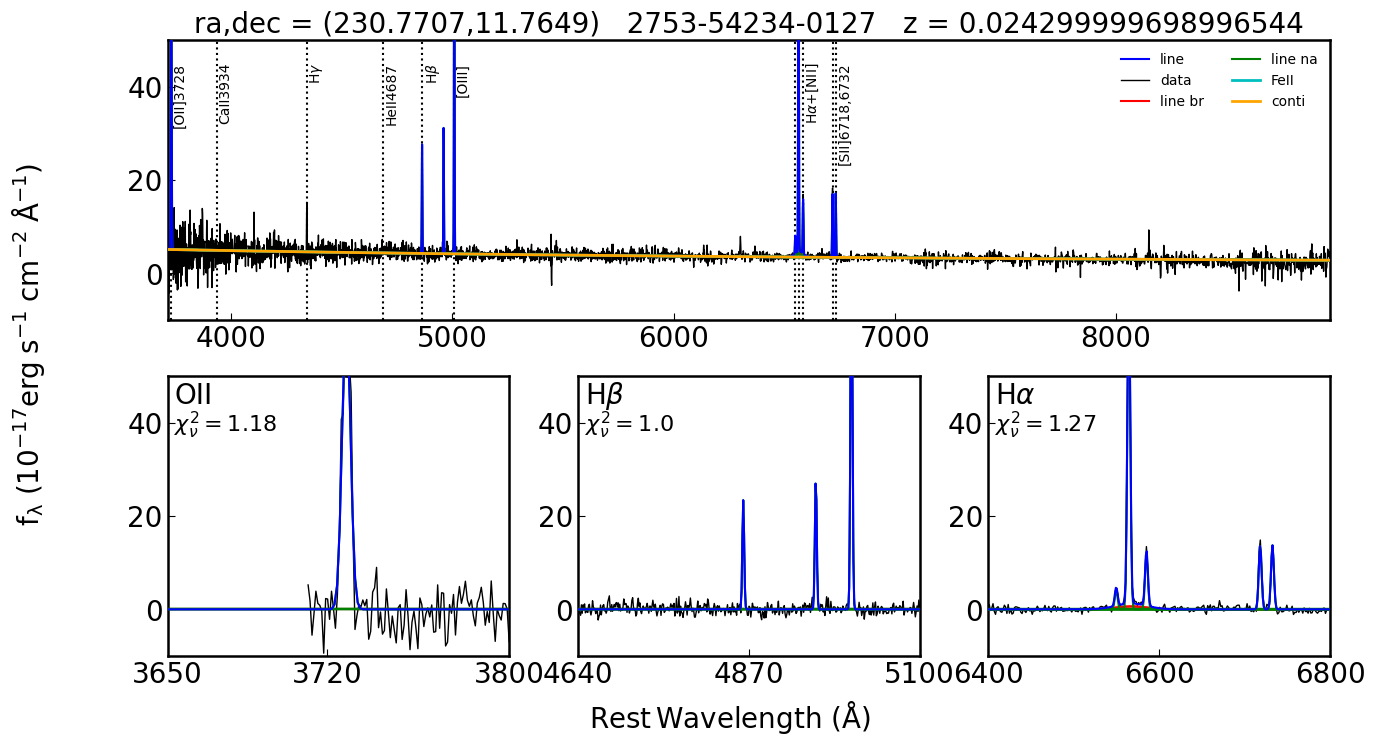

In [36]:
# Prepare data
q0 = QSOFit(lam, flux, err, z, ra=ra, dec=dec, plateid=plateid, mjd=mjd, fiberid=fiberid, path=path_ex)

start = timeit.default_timer()
# Do the fitting
q0.Fit(name=None, nsmooth=1, and_or_mask=False, deredden=True, reject_badpix=False, wave_range=None, \
      wave_mask=None, decompose_host=False, BC03=False, use_ppxf=False, Mi=None, npca_gal=10, npca_qso=2, Fe_uv_op=False, \
      Fe_flux_range=np.array([4435,4685]), poly=False, BC=False, rej_abs=False, initial_guess=None, \
      method='leastsq', linefit=True,  epsilon_jitter=1e-5, \
      save_result=False, plot_fig=True, save_fig=False, plot_line_name=True, ylims=[-10, 50],\
      plot_legend=True, save_fig_path='.', save_fits_path=path_out, save_fits_name=None, verbose=False)

end = timeit.default_timer()

print(f'Fitting finished in {np.round(end - start, 1)}s')


__Run PyQSOFit with `decompose_host=True` and `use_ppxf=True` to use pPXF for the host component:__

This will take much longer however.

Run with `use_ppxf=False` to compare the result using the result from PyQSOFit's PCA decomposition with built-in host templates. 

69.13022132314651
[69.02975368]
Emission lines included in gas templates:
['H10' 'H9' 'H8' 'Heps' 'Hdelta' 'Hgamma' 'Hbeta' 'Halpha' '[OII]3726'
 '[OII]3729' '[SII]6716' '[SII]6731' '[NeIII]3968' '[NeIII]3869'
 'HeII4687' 'HeI5876' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
[False False False False  True  True  True  True  True  True False False
 False False False False  True False  True]
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       -72       189     0.018    -0.114
 comp.  1:       -46       122    -0.144     0.109
 comp.  2:       -12        22     0.005    -0.006
chi2/DOF: 0.09763; DOF: 2873; degree = -1; mdegree = 10
method = capfit; Jac calls: 10; Func calls: 234; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 8/169
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                   H10   

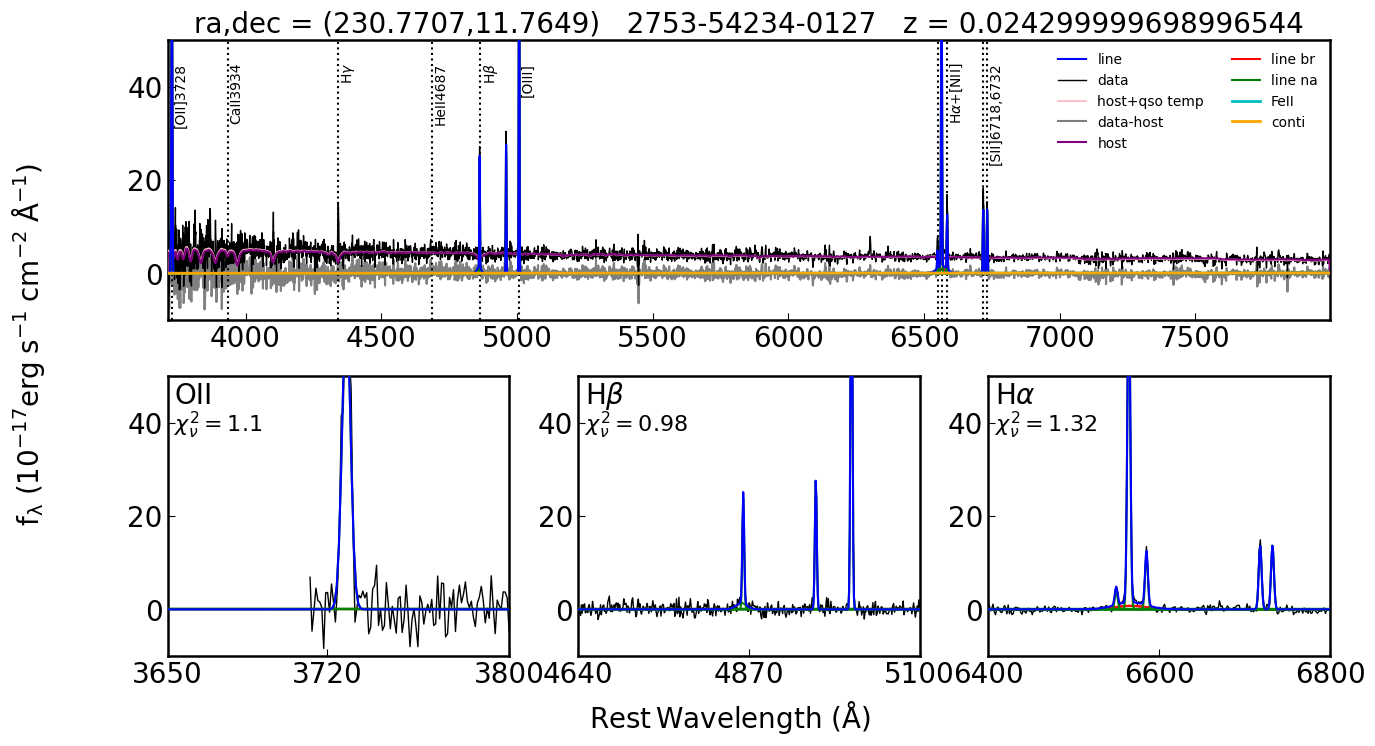

In [37]:
# Prepare data
q1 = QSOFit(lam, flux, err, z, ra=ra, dec=dec, plateid=plateid, mjd=mjd, fiberid=fiberid, path=path_ex)

start = timeit.default_timer()
# Do the fitting
q1.Fit(name=None, nsmooth=1, and_or_mask=False, deredden=True, reject_badpix=False, wave_range=None, \
      wave_mask=None, decompose_host=True, use_ppxf=True, Mi=None, npca_gal=10, npca_qso=2, Fe_uv_op=False, \
      Fe_flux_range=np.array([4435,4685]), poly=False, BC=False, rej_abs=False, initial_guess=None, \
      method='leastsq', linefit=True,  epsilon_jitter=1e-5, \
      save_result=False, plot_fig=True, save_fig=False, plot_line_name=True, ylims=[-10, 50],\
      plot_legend=True, save_fig_path='.', save_fits_path=path_out, save_fits_name=None, verbose=False)

end = timeit.default_timer()

print(f'Fitting finished in {np.round(end - start, 1)}s')

__Do the fitting again, but with 2 components for the H$\alpha$ broad line__

In [38]:
# Change the number of Gaussians for the Ha line in the line parameter file
newdata_n = newdata.copy()


for i, row in enumerate(newdata_n):

    if 'Ha_br' in str(row['linename']):
        newdata_n[i]['ngauss'] = 2

hdu = fits.BinTableHDU(data=newdata_n, header=hdr, name='data')
hdu.writeto(os.path.join(path_ex, 'qsopar.fits'), overwrite=True)

from astropy.table import Table
Table(newdata_n)

lambda,compname,minwav,maxwav,linename,ngauss,inisca,minsca,maxsca,inisig,minsig,maxsig,voff,vindex,windex,findex,fvalue,vary
float32,bytes20,float32,float32,bytes20,int32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,float32,int32
6564.61,H$\alpha$,6400.0,6800.0,Ha_br,2,0.1,0.0,10000000000.0,0.005,0.00022222222,0.0027777778,0.0015,0,0,0,0.05,1
6564.61,H$\alpha$,6400.0,6800.0,Ha_na,1,0.1,0.0,10000000000.0,0.001,5e-05,0.0017,0.01,1,1,0,0.002,1
6549.85,H$\alpha$,6400.0,6800.0,NII6549,1,0.1,0.0,10000000000.0,0.001,2.3e-05,0.0017,0.005,1,1,1,0.001,1
6585.28,H$\alpha$,6400.0,6800.0,NII6585,1,0.1,0.0,10000000000.0,0.001,2.3e-05,0.0017,0.005,1,1,1,0.003,1
6718.29,H$\alpha$,6400.0,6800.0,SII6718,1,0.1,0.0,10000000000.0,0.001,2.3e-05,0.0017,0.005,1,1,2,0.001,1
6732.67,H$\alpha$,6400.0,6800.0,SII6732,1,0.1,0.0,10000000000.0,0.001,2.3e-05,0.0017,0.005,1,1,2,0.001,1
4862.68,H$\beta$,4640.0,5100.0,Hb_br,1,0.1,0.0,10000000000.0,0.0005,0.0004,0.005,0.01,0,0,0,0.01,1
4862.68,H$\beta$,4640.0,5100.0,Hb_na,1,0.1,0.0,10000000000.0,0.001,0.00023,0.0017,0.01,1,1,0,0.002,1
4960.3,H$\beta$,4640.0,5100.0,OIII4959c,1,0.1,0.0,10000000000.0,0.001,0.00023,0.0017,0.01,1,1,0,0.002,1


69.13022132314651
[69.02975368]
Emission lines included in gas templates:
['H10' 'H9' 'H8' 'Heps' 'Hdelta' 'Hgamma' 'Hbeta' 'Halpha' '[OII]3726'
 '[OII]3729' '[SII]6716' '[SII]6731' '[NeIII]3968' '[NeIII]3869'
 'HeII4687' 'HeI5876' '[OIII]5007_d' '[OI]6300_d' '[NII]6583_d']
[False False False False  True  True  True  True  True  True False False
 False False False False  True False  True]
 Best Fit:       Vel     sigma        h3        h4
 comp.  0:         9         7    -0.005     0.002
 comp.  1:       -30        10    -0.009    -0.007
 comp.  2:       -13        22    -0.001    -0.005
chi2/DOF: 0.09560; DOF: 2873; degree = -1; mdegree = 10
method = capfit; Jac calls: 16; Func calls: 375; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 9/169
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1                   H10   

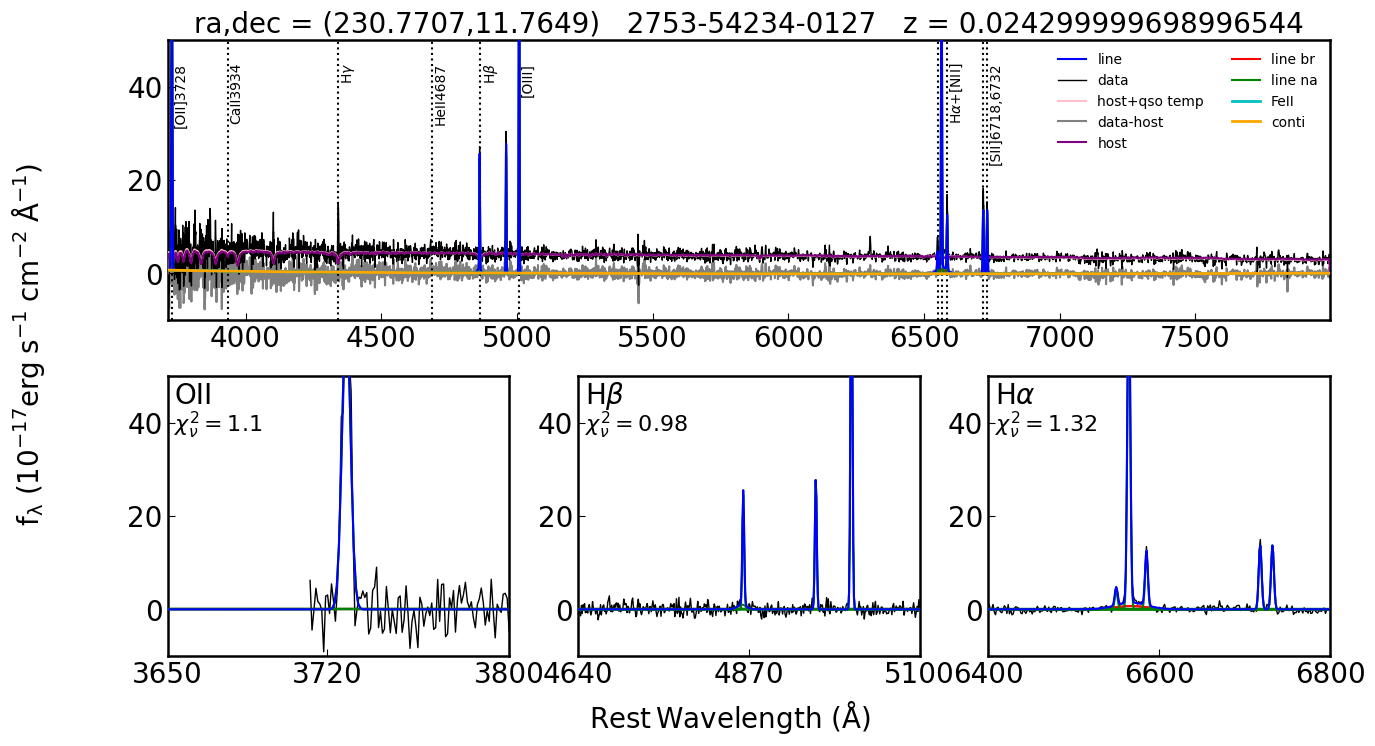

In [39]:
# Prepare data
q2 = QSOFit(lam, flux, err, z, ra=ra, dec=dec, plateid=plateid, mjd=mjd, fiberid=fiberid, path=path_ex)

start = timeit.default_timer()
# Do the fitting
q2.Fit(name=None, nsmooth=1, and_or_mask=False, deredden=True, reject_badpix=False, wave_range=None, \
      wave_mask=None, decompose_host=True, use_ppxf=True, Mi=None, npca_gal=10, npca_qso=2, Fe_uv_op=True, \
      Fe_flux_range=np.array([4435,4685]), poly=True, BC=False, rej_abs=False, initial_guess=None, \
      method='leastsq', linefit=True,  epsilon_jitter=1e-5, \
      save_result=False, plot_fig=True, save_fig=False, plot_line_name=True, ylims=[-10, 50],\
      plot_legend=True, save_fig_path='.', save_fits_path=path_out, save_fits_name=None, verbose=False)

end = timeit.default_timer()

print(f'Fitting finished in {np.round(end - start, 1)}s')

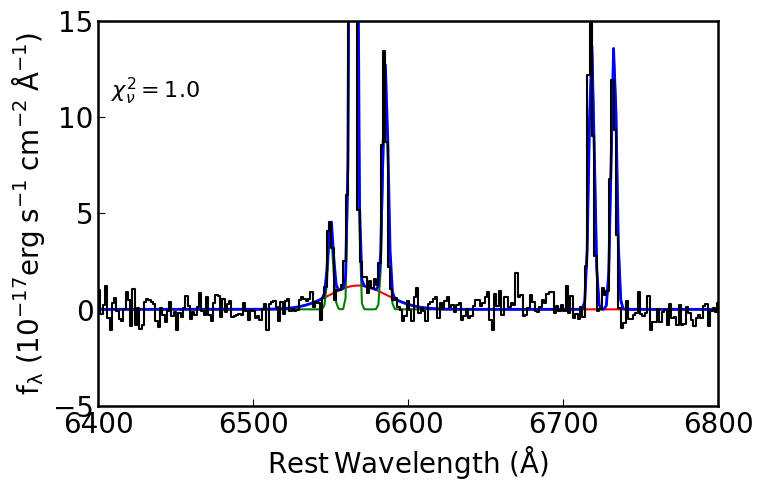

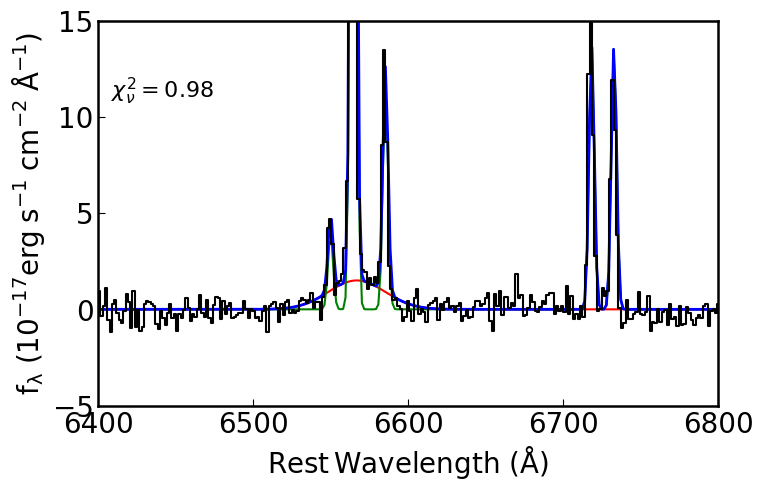

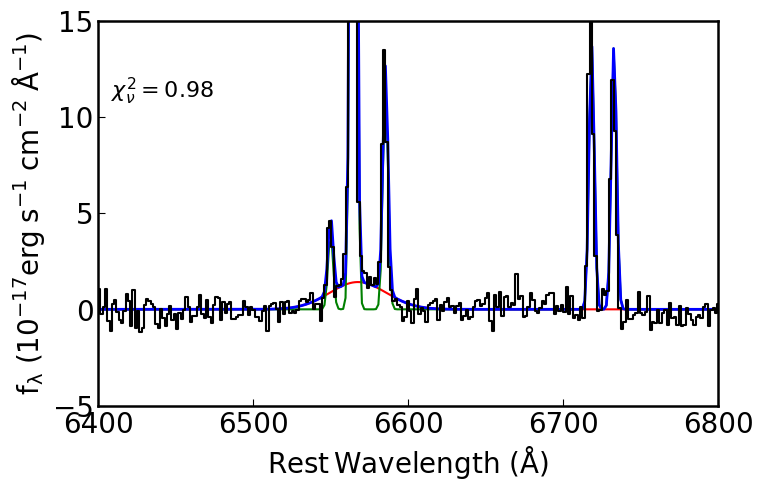

In [40]:
# Plot the result
for q in [q0, q1, q2]:

    if q.MCMC:
        gauss_result = q.gauss_result[::2]
    else:
        gauss_result = q.gauss_result

    fig, ax = plt.subplots(1, 1, figsize=(8,5))

    # Plot individual line components
    lines_na = np.zeros_like(q.wave)
    lines_br = np.zeros_like(q.wave)
    for p in range(len(gauss_result)//3):
        if q.CalFWHM(gauss_result[3*p+2]) < 1200:  # < 1200 km/s narrow
            lines_na += q.Onegauss(np.log(q.wave), gauss_result[p*3:(p+1)*3])
        else:
            lines_br += q.Onegauss(np.log(q.wave), gauss_result[p*3:(p+1)*3])
        
    
    ax.plot(q.wave, lines_br, color='r')
    ax.plot(q.wave, lines_na, color='g')

    # Plot total line model
    ax.plot(q.wave, q.Manygauss(np.log(q.wave), gauss_result), 'b', lw=2)
    ax.step(q.wave, q.line_flux,'k')
    ax.set_xlim(6400, 6800)
    ax.set_ylim(-5, 15)
    ax.set_xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)', fontsize=20)
    ax.set_ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)', fontsize=20)

    c = 1 # Ha
    ax.text(0.02, 0.80, r'$\chi ^2_\nu=$'+str(np.round(float(q.comp_result[c*7+4]), 2)),
                               fontsize=16, transform=ax.transAxes)

The $\chi^2$ has not improved much between q1 and q2, so we stick with the first result with a single broad line component.

In [41]:
# Result without host decomposition

fwhm, sigma, ew, peak, area = q0.line_prop_from_name('Ha_br', 'broad')

# We should correct for the instrumental resolution ~69 km/s
# http://classic.sdss.org/dr5/algorithms/veldisp.html#:~:text=The%20instrumental%20dispersion%20of%20the,can%20affect%20measurements%20of%20sigma%20.
sigma_sdss = 69

print("Broad Ha:")
print("FWHM (km/s)", np.round(fwhm, 1))
print("Sigma (km/s)", np.round(sigma, 1))
print("EW (A)", np.round(ew, 1))
print("Peak (A)", np.round(peak, 1))
print("area (10^(-17) erg/s/cm^2)", np.round(area, 1))
print("L (erg/s)", np.round(q0.flux2L(area), 1))

# Use the Reines 2013 equation to get BH mass
epsilon = 1
logM_BH = np.log10(epsilon) + 6.57 + 0.47*np.log10(q0.flux2L(area)/1e42) + 2.06*np.log10(fwhm/1e3)

print("M_BH (M_Sun)", np.round(logM_BH, 1))


Broad Ha:
FWHM (km/s) 1963.6
Sigma (km/s) 822.7
EW (A) 16.2
Peak (A) 6568.4
area (10^(-17) erg/s/cm^2) 56.4
L (erg/s) 7.582939258182421e+38
M_BH (M_Sun) 5.7


In [42]:
# Result with pPXF host decomposition

fwhm, sigma, ew, peak, area = q1.line_prop_from_name('Ha_br', 'broad')

print("Broad Ha:")
print("FWHM (km/s)", np.round(fwhm, 1))
print("Sigma (km/s)", np.round(sigma, 1))
print("EW (A)", np.round(ew, 1))
print("Peak (A)", np.round(peak, 1))
print("area (10^(-17) erg/s/cm^2)", np.round(area, 1))
print("L (erg/s)", np.round(q1.flux2L(area), 1))

# Use the Reines 2013 equation to get BH mass
epsilon = 1
logM_BH = np.log10(epsilon) + 6.57 + 0.47*np.log10(q1.flux2L(area)/1e42) + 2.06*np.log10(fwhm/1e3)

print("M_BH (M_Sun)", np.round(logM_BH, 1))

Broad Ha:
FWHM (km/s) 1962.9
Sigma (km/s) 821.8
EW (A) 1712.3
Peak (A) 6566.0
area (10^(-17) erg/s/cm^2) 68.5
L (erg/s) 9.2116984551817e+38
M_BH (M_Sun) 5.7
